# DoA Estimation using SubSpaceNet

In this notebook we apply model-based deep learning for DoA estimation algorithm, by augmenting a dedicated deep network for learning to produce a decomposable covariance that is useful MUSIC and Root-MUSIC. We demonstrate how it allows to these algorithms to be applied when their underlying assumptions (e.g., non-coherent sources) no longer hold.

##Preparations

To avoid formulating the entire setup, we will clone code available in GitHub for subspace-based DoA estimation, using the syntex below.

In [1]:
!git clone https://github.com/ShlezingerLab/SubspaceNet.git

Cloning into 'SubspaceNet'...
remote: Enumerating objects: 541, done.
remote: Counting objects: 100% (541/541), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 541 (delta 339), reused 478 (delta 291), pack-reused 0
Receiving objects: 100% (541/541), 5.12 MiB | 20.25 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [2]:
# Imports
import sys
import torch
import os
import matplotlib.pyplot as plt
import warnings
sys.path.append(r'/content/SubspaceNet')

from src.system_model import SystemModelParams
from src.signal_creation import *
from src.data_handler import *
from src.criterions import set_criterions
from src.training import *
from src.plotting import initialize_figures
from pathlib import Path
from src.models import ModelGenerator


We export the data paths from the repository##Configurations

In [3]:
# Initialize paths
external_data_path = Path.cwd() / "SubspaceNet/data"
scenario_data_path = "diff_esprit"

datasets_path = external_data_path / "datasets" / scenario_data_path
simulations_path = external_data_path / "simulations"
saving_path = external_data_path / "weights"

# Operations commands
commands = {
        "LOAD_MODEL": True,  # Load specific model for training
        "TRAIN_MODEL": True,  # Applying training operation
        "EVALUATE_MODE": True,  # Evaluating desired algorithms
    }
# Saving simulation scores to external file

# Define system model parameters
system_model_params = (
    SystemModelParams()
    .set_num_sensors(8)
    .set_num_sources(3)
    .set_num_observations(100)
    .set_snr(10)
    .set_signal_type("NarrowBand")
    .set_signal_nature("coherent")
    .set_sensors_dev(eta=0)
    .set_sv_noise(0)
)
# Generate model configuration
model_config = (
    ModelGenerator()
    .set_model_type("SubspaceNet")
    .set_diff_method("root_music")
    .set_tau(8)
    .set_model(system_model_params)
)

# Sets simulation filename
simulation_filename = get_simulation_filename(
    system_model_params=system_model_params, model_config=model_config
)
# Initialize seed
set_unified_seed()

The imported package allows generating data of the form
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{A}(\boldsymbol{s})\boldsymbol{y}_t + \boldsymbol{w}_t,
\end{equation}
where $\boldsymbol{A}(\boldsymbol{s})$ is the steering matrix for the DoAs in $\boldsymbol{s}$.

We next use this model to generate data stemming from only from coherent sources, in order to show how deep learning can allow classic subspace-based DoA recovery in settings where model-based methods fail.

In [4]:
# Define samples size
samples_size = 100  # Overall dateset size
train_test_ratio = 1  # training and testing datasets ratio

print("Creating coherent train Dataset")
# Generate training dataset
train_dataset, _, _ = create_dataset(
    system_model_params=system_model_params,
    samples_size=samples_size,
    model_type=model_config.model_type,
    tau=model_config.tau,
    save_datasets=True,
    datasets_path=datasets_path,
    true_doa=None,
    phase="train",
    )


print("Creating coherent test Dataset")
# Generate test dataset
test_dataset, generic_test_dataset, samples_model = create_dataset(
    system_model_params=system_model_params,
    samples_size=int(train_test_ratio * samples_size),
    model_type=model_config.model_type,
    tau=model_config.tau,
    save_datasets=True,
    datasets_path=datasets_path,
    true_doa=None,
    phase="test",
)


Creating coherent train Dataset


100%|██████████| 100/100 [00:10<00:00,  9.55it/s]


Creating coherent test Dataset


100%|██████████| 100/100 [00:07<00:00, 13.39it/s]


## Training SubspaceNet

The model-based/data-driven implementation coined *SubspaceNet* uses a denoising autoencoder for mapping the empirical autocorrelation into a covariance matrix that is useful for subspace-based recovery. This is achieved by leveraging the differntiability of RootMUSIC and training the matrix by evaluating the ability of RootMUSIC to identify the angles based on its learned covariance.

In the sequel we load trained weights. The code below is used simply to exemplify how it can be trained (though larger data sets are typically required compared to what is included here).

Training DataSet size 90
Validation DataSet size 10

--- New Simulation ---

Description: Simulation of SubspaceNet, training stage
System model parameters:
Number of sources = 3
Number of sensors = 8
signal_type = NarrowBand
Observations = 100
SNR = 10, coherent sources
Spacing deviation (eta) = 0
Geometry noise variance = 0
Simulation parameters:
Model: SubspaceNet
SubspaceNet: tau = 8
SubspaceNet: differentiable subspace method  = root_music
Epochs = 10
Batch Size = 2048
Learning Rate = 1e-05
Weight decay = 1e-09
Gamma Value = 0.2
Step Value = 80

----------------------

date and time = 15/08/2023 08:58:22

---Start Training Stage ---



100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


epoch : 1/10, Train loss = 0.072464, Validation loss = 0.128130
lr 1e-05
Validation Loss Decreased(inf--->0.128130) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


epoch : 2/10, Train loss = 0.084088, Validation loss = 0.128097
lr 1e-05
Validation Loss Decreased(0.128130--->0.128097) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


epoch : 3/10, Train loss = 0.076138, Validation loss = 0.128050
lr 1e-05
Validation Loss Decreased(0.128097--->0.128050) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


epoch : 4/10, Train loss = 0.069442, Validation loss = 0.127978
lr 1e-05
Validation Loss Decreased(0.128050--->0.127978) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


epoch : 5/10, Train loss = 0.078454, Validation loss = 0.127878
lr 1e-05
Validation Loss Decreased(0.127978--->0.127878) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


epoch : 6/10, Train loss = 0.072048, Validation loss = 0.127800
lr 1e-05
Validation Loss Decreased(0.127878--->0.127800) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


epoch : 7/10, Train loss = 0.078541, Validation loss = 0.127713
lr 1e-05
Validation Loss Decreased(0.127800--->0.127713) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


epoch : 8/10, Train loss = 0.075535, Validation loss = 0.127620
lr 1e-05
Validation Loss Decreased(0.127713--->0.127620) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


epoch : 9/10, Train loss = 0.075079, Validation loss = 0.127527
lr 1e-05
Validation Loss Decreased(0.127620--->0.127527) 	 Saving The Model


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


epoch : 10/10, Train loss = 0.080103, Validation loss = 0.127433
lr 1e-05
Validation Loss Decreased(0.127527--->0.127433) 	 Saving The Model

--- Training summary ---
Training complete in 0m 7s
Minimal Validation loss: 0.127433 at epoch 9


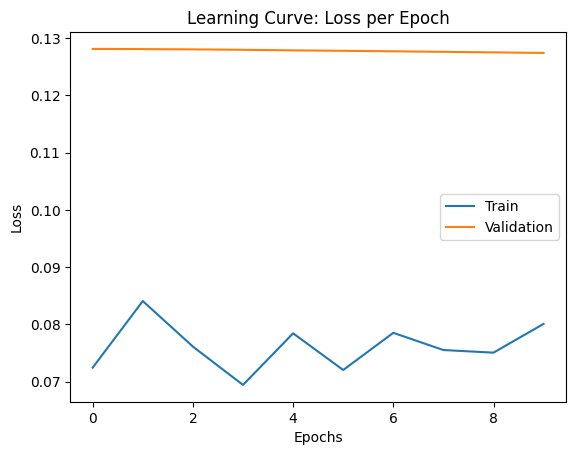

In [5]:
if commands["TRAIN_MODEL"]:
    # Assign the training parameters object
    simulation_parameters = (
        TrainingParams()
        .set_batch_size(2048)
        .set_epochs(10)
        # .set_model(system_model=samples_model, tau=model.tau, diff_method=model.diff_method)
        .set_model(model=model_config)
        .set_optimizer(optimizer="Adam", learning_rate=0.00001, weight_decay=1e-9)
        .set_training_dataset(train_dataset)
        .set_schedular(step_size=80, gamma=0.2)
        .set_criterion()
    )
    if commands["LOAD_MODEL"]:
        simulation_parameters.load_model(
            loading_path=saving_path / "final_models" / simulation_filename
        )
    # Print training simulation details
    simulation_summary(
        system_model_params=system_model_params,
        model_type=model_config.model_type,
        parameters=simulation_parameters,
        phase="training",
    )
    # Perform simulation training and evaluation stages
    model, loss_train_list, loss_valid_list = train(
        training_parameters=simulation_parameters,
        model_name=simulation_filename,
        saving_path=saving_path,
    )


    plt.show()

### Loadin pre-trained model

In [7]:
simulation_summary(
    system_model_params=system_model_params,
    model_type=model_config.model_type,
    phase="evaluation",
    parameters=simulation_parameters,
)


--- New Simulation ---

Description: Simulation of SubspaceNet, evaluation stage
System model parameters:
Number of sources = 3
Number of sensors = 8
signal_type = NarrowBand
Observations = 100
SNR = 10, coherent sources
Spacing deviation (eta) = 0
Geometry noise variance = 0
Simulation parameters:
Model: SubspaceNet
SubspaceNet: tau = 8
SubspaceNet: differentiable subspace method  = root_music


### AutoEncoder model

In [8]:
from torchsummary import summary
summary(model, test_dataset[0][0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 16, 15, 7]             528
              ReLU-2            [-1, 16, 15, 7]               0
              ReLU-3            [-1, 16, 15, 7]               0
            Conv2d-4            [-1, 32, 14, 6]           4,128
              ReLU-5            [-1, 32, 14, 6]               0
              ReLU-6            [-1, 32, 14, 6]               0
            Conv2d-7            [-1, 64, 13, 5]          16,448
              ReLU-8            [-1, 64, 13, 5]               0
              ReLU-9            [-1, 64, 13, 5]               0
  ConvTranspose2d-10            [-1, 32, 14, 6]          16,416
             ReLU-11            [-1, 32, 14, 6]               0
             ReLU-12            [-1, 32, 14, 6]               0
  ConvTranspose2d-13            [-1, 16, 15, 7]           4,112
             ReLU-14            [-1, 16

# Evaluation Process

We next show how the trained SubspaceNet allows both RootMUSIC and MUSIC to operate reliably and provide meaningful spectrum despite the coherence of the sources.

In [6]:
# Initialize figures dict for plotting
figures = initialize_figures()

# Define loss measure for evaluation
criterion, subspace_criterion = set_criterions("rmse")

# Generate DataLoader objects
model_test_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
generic_test_dataset = torch.utils.data.DataLoader(generic_test_dataset, batch_size=1, shuffle=False, drop_last=False)

Loss measure = rmse


SubspaceNet + Root-MUSIC

SubspaceNet Test loss = 0.07639908711604297


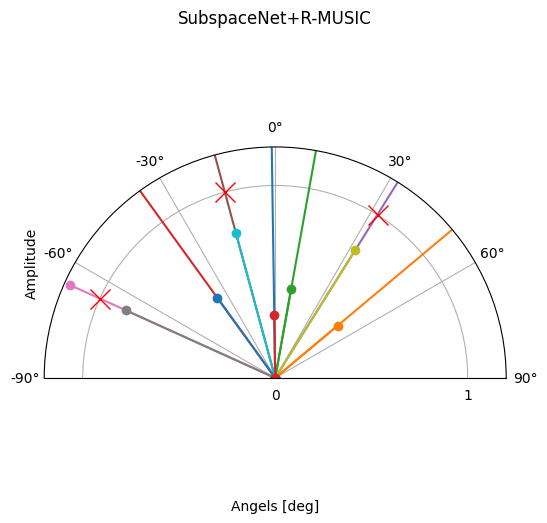

In [9]:
spec_path = 'data/spectrums'
if not os.path.exists(spec_path):
  os.makedirs(spec_path) #TODO Dor, bugfix - should savefig only if SAVE_FIG=False

# Evaluate SubspaceNet + differentiable algorithm performances
model_test_loss = evaluate_dnn_model(
    model=model,
    dataset=model_test_dataset,
    criterion=criterion,
    plot_spec=True,
    figures=figures,
    model_type=model_config.model_type)

plt.title('SubspaceNet+{0}'.format("R-MUSIC"))


print(f"{model_config.model_type} Test loss = {model_test_loss}")
plt.show()

SubspaceNet + MUSIC

augmented music test loss = 0.12464773969672764


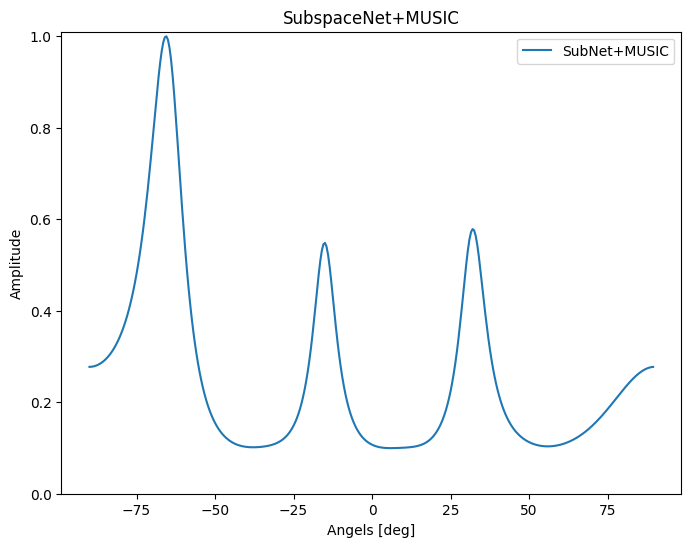

In [10]:
from src.evaluation import evaluate_augmented_model

algorithm = "music"

loss = evaluate_augmented_model(
    model=model,
    dataset=model_test_dataset,
    system_model=samples_model,
    criterion=subspace_criterion,
    algorithm=algorithm,
    plot_spec=True,
    figures=figures)

plt.title('SubspaceNet+{0}'.format(algorithm.upper()))
print("augmented {} test loss = {}".format(algorithm, loss))

plt.show()
